## **1. Import Libraries**


In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

import joblib

print("Libraries imported.")

Libraries imported.


## **2. Load Dataset**



In [15]:
df = pd.read_csv('/content/drive/MyDrive/Lab1_TK/household.csv', parse_dates=['date'], low_memory=True)
df = df.set_index('date').sort_index()
df = df.drop(columns=['main','description'], errors='ignore')

print("Dataset shape:", df.shape)
df

Dataset shape: (605260, 16)


,active_power,current,voltage,reactive_power,apparent_power,power_factor,temp,feels_like,temp_min,temp_max,pressure,humidity,speed,deg,temp_t+1,feels_like_t+1
date,,,,,,,,,,,,,,,,
2022-11-05 14:05:00,265.1,2.53,122.2,159.09,309.17,0.8575,24.19,23.68,23.44,27.50,1013,39,0.00,0,29.63,27.97
2022-11-05 14:06:00,265.1,2.53,122.2,159.09,309.17,0.8575,24.19,23.68,23.44,27.50,1013,39,0.00,0,29.63,27.97
2022-11-05 14:07:00,265.1,2.53,122.2,159.09,309.17,0.8575,24.19,23.68,23.44,27.50,1013,39,0.00,0,29.63,27.97
2022-11-05 14:08:00,640.0,5.45,120.7,152.08,657.82,0.9729,24.19,23.68,23.44,27.50,1013,39,0.00,0,29.63,27.97
2022-11-05 14:09:00,257.6,2.47,122.4,158.26,302.33,0.8520,24.19,23.68,23.44,27.50,1013,39,0.00,0,29.63,27.97
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-01-05 23:55:00,316.3,2.53,129.1,81.46,326.62,0.9684,12.32,10.65,8.07,13.96,1012,40,2.05,160,13.99,12.75
2024-01-05 23:56:00,1526.3,13.58,124.8,736.67,1694.78,0.9006,12.76,11.11,8.07,13.96,1012,39,2.05,160,13.99,12.75
2024-01-05 23:57:00,1528.7,13.56,124.9,729.04,1693.64,0.9026,12.32,10.65,8.07,13.96,1012,40,2.05,160,13.96,12.72


## **3. Feature Engineering**


In [23]:
data = df.copy()

# Lag features
data['ap_lag_1h'] = data['active_power'].shift(1)
data['ap_lag_24h'] = data['active_power'].shift(24)
data['ap_roll_24h'] = data['active_power'].rolling(24).mean()

# Time features
data['hour'] = data.index.hour
data['weekday'] = data.index.weekday
data['is_weekend'] = (data['weekday'] >= 5).astype(int)

# Keep only useful columns
keep = [
    'active_power','ap_lag_1h','ap_lag_24h','ap_roll_24h',
    'temp','feels_like','humidity','pressure','speed',
    'current','voltage','apparent_power','hour','weekday','is_weekend'
]
keep = [c for c in keep if c in data.columns]

data = data[keep].dropna().copy()

print("After feature engineering shape:", data.shape)
data

After feature engineering shape: (605236, 15)


,active_power,ap_lag_1h,ap_lag_24h,ap_roll_24h,temp,feels_like,humidity,pressure,speed,current,voltage,apparent_power,hour,weekday,is_weekend
date,,,,,,,,,,,,,,,
2022-11-05 14:29:00,257.6,257.6,265.1,274.158333,23.89,23.35,39,1013,0.00,2.47,122.4,302.33,14,5,1
2022-11-05 14:30:00,257.6,257.6,265.1,273.845833,23.89,23.35,39,1013,0.00,2.47,122.4,302.33,14,5,1
2022-11-05 14:31:00,257.6,257.6,265.1,273.533333,23.89,23.35,39,1013,0.00,2.47,122.4,302.33,14,5,1
2022-11-05 14:32:00,257.6,257.6,640.0,257.600000,23.89,23.35,39,1013,0.00,2.47,122.4,302.33,14,5,1
2022-11-05 14:33:00,257.6,257.6,257.6,257.600000,23.89,23.35,39,1013,0.00,2.47,122.4,302.33,14,5,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-01-05 23:55:00,316.3,316.3,159.8,177.975000,12.32,10.65,40,1012,2.05,2.53,129.1,326.62,23,4,0
2024-01-05 23:56:00,1526.3,316.3,159.8,234.912500,12.76,11.11,39,1012,2.05,13.58,124.8,1694.78,23,4,0
2024-01-05 23:57:00,1528.7,1526.3,159.8,291.950000,12.32,10.65,40,1012,2.05,13.56,124.9,1693.64,23,4,0


## **4. Train-Validate-Test Split (Time-based)**


In [17]:
TARGET = 'active_power'

X = data.drop(columns=[TARGET])
y = data[TARGET]

train_end = int(len(X) * 0.85)
val_end = int(len(X) * 0.95)
X_train, X_val, X_test = X.iloc[:train_end], X.iloc[train_end:val_end], X.iloc[val_end:]
y_train, y_val, y_test = y.iloc[:train_end], y.iloc[train_end:val_end], y.iloc[val_end:]

print("Train shape:", X_train.shape)
print("Validate shape:", X_val.shape)
print("Test shape:", X_test.shape)

Train shape: (484188, 14)
Test shape: (121048, 14)


## **5. Scaling**



In [18]:
scaler = StandardScaler()
X_train_s = scaler.fit_transform(X_train)
X_val_s = scaler.transform(X_val)
X_test_s = scaler.transform(X_test)

print("Scaling completed.")

Scaling completed.


## **6. Train Model using GridSearchCV + TimeSeriesSplit**



In [19]:
model = DecisionTreeRegressor(random_state=42)

param_grid = {
    'max_depth': [5, 8, None],
    'min_samples_leaf': [1, 2, 4]
}

tscv = TimeSeriesSplit(n_splits=5)

gscv = GridSearchCV(model, param_grid,
                    scoring='neg_mean_absolute_error',
                    cv=tscv, n_jobs=-1)

gscv.fit(X_train_s, y_train)

best = gscv.best_estimator_
print("Best parameters:", gscv.best_params_)

Best parameters: {'max_depth': None, 'min_samples_leaf': 4}


## **7. Evaluate Model Performance**



In [20]:
y_pred = best.predict(X_test_s)

mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print("MAE :", mae)
print("RMSE:", rmse)
print("R²  :", r2)

MAE : 5.942639437600015
RMSE: 17.350752863272298
R²  : 0.9900849432203106


## **8. Feature Importance**



In [21]:
importances = pd.Series(best.feature_importances_, index=X_train.columns)
importances.sort_values(ascending=False).head(10)

,0
apparent_power,0.974047
ap_lag_1h,0.020293
current,0.004544
ap_roll_24h,0.000269
ap_lag_24h,0.000146
hour,0.000135
humidity,0.000132
voltage,0.000119
pressure,0.000078
temp,0.000076


## **9. Visualization — Actual vs Predicted (Sample)**


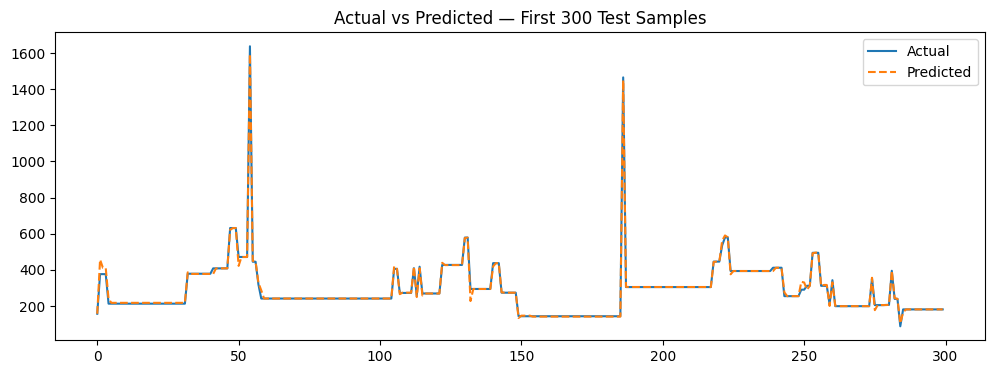

In [22]:
plt.figure(figsize=(12,4))
plt.plot(y_test.values[:300], label="Actual")
plt.plot(y_pred[:300], label="Predicted", linestyle="--")
plt.legend()
plt.title("Actual vs Predicted — First 300 Test Samples")
plt.show()